# Projet GouvImmo, partie 4: Modèle de régression (Lasso)

### Introduction:

Ce notebook à pour but d'effectuer un modèle de régression, dans le cadre du projet fil rouge "GouvImmo" chez Datascientest. 

### Jeu de données:

Les données ont été préalablement importés, fusionnées puis triées dans les notebook nommés gouvimmo_project_part1, gouvimmo_project_part2 et gouvimmo_project_part3 et sauvegardés dans un fichier csv nommé IDF_2019_to_2021_v3.csv

Le dataframe comporte les données de ventes immobilières de la région Ile de France, de 2019 à 2021. Il comporte des variables relatives à la localisation du bien, au type de bien vendu, à sa valeur et à ses carractéristiques (surface, nombre de pièces, nombre de dépendances, ...). 

Le but du modèle de régression est de déterminer la variable cible "Valeur foncière".

# Importation des librairies et du fichier de données en csv:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
pd.pandas.set_option('display.max_columns',None)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso, LassoCV

In [ ]:
df=pd.read_csv("IDF_2019_to_2021_v3.csv")
df.head()

,id_mutation,valeur_fonciere,date_mutation,numero_disposition,nature_mutation,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,id_parcelle,nombre_lots,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,Appartement,Dépendance,Maison,terrains_a_batir,terrains_autre,prix_m²,section_cadastrale,prix_m²_moy_ca,prix_m²_moy_co,annee,code_annee,type_bien
0,2019-1135463,310000.0,2019-01-03,1.0,Vente,11.0,NaN,RUE DE LA FONTAINE,0650,77220.0,77215,Gretz-Armainvilliers,77,772150000B0473,0,101.0,4.0,855.0,2.740574,48.739669,0,0,1,0,1,3069.31,772150000B,3646.883495,3474.511880,2019,0,Maison
1,2019-1135466,155000.0,2019-01-04,1.0,Vente,4.0,NaN,AV DE LA GARE,0600,77340.0,77373,Pontault-Combault,77,77373000AD0157,2,51.0,2.0,0.0,2.616840,48.805639,1,1,0,0,0,3039.22,77373000AD,3804.018010,3759.720085,2019,0,Appartement
2,2019-1135467,165500.0,2019-01-09,1.0,Vente,45.0,NaN,RUE LOUIS VICTOR DE BROGLIE,1413,77176.0,77445,Savigny-le-Temple,77,77445000YA0444,3,64.0,3.0,12.0,2.565832,48.605740,1,2,0,0,0,2585.94,77445000YA,2821.665116,2610.471778,2019,0,Appartement
3,2019-1135468,269000.0,2019-01-02,1.0,Vente,6.0,NaN,RUE JEAN FERRAT,0492,77310.0,77407,Saint-Fargeau-Ponthierry,77,77407000AY0353,0,84.0,4.0,270.0,2.553743,48.530118,0,0,1,0,2,3202.38,77407000AY,2815.332174,2679.428891,2019,0,Maison
4,2019-1135469,199500.0,2019-01-08,1.0,Vente,3.0,NaN,RUE DE LA PICARDIE,0186,77720.0,77211,Grandpuits-Bailly-Carrois,77,772110170D0147,0,109.0,5.0,1036.0,2.993174,48.576719,0,0,1,0,2,1830.28,772110170D,2360.692500,2020.605714,2019,0,Maison


# Preprocessing:

Dans le précédent notebook, portant sur la dataviz, 3 variables avaient été créées à partire de la variable cible: "prix_m²", "prix_m²_moy_ca", et "prix_m²_moy_co". Ces 3 variables étant issues de la variable cible "valeur_fonciere", elles ne doivent pas êtres incluses dans le modèle de régression. Nous allons donc les retirer.

In [ ]:
#Retrait des variables prix/m² car créées via la variables cible pour le data viz, et ne devant pas êtres incluses dans le modèle
df=df.drop(["prix_m²_moy_ca", "prix_m²_moy_co", "prix_m²"], axis=1)

Nous allons nous concentrer sur le modèle Lasso dans ce notebook. Nous allons sélectionner toute les variables numériques de notre dataset, pour créer les ensembles d'entrainement et de test, que nous standardiserons.  

In [ ]:
#Sélection des variables numériques de df pour le modèle de régression:
num_df=df.select_dtypes(include=['int','float', "uint8"]).dropna(axis = 0, how = 'any')

#Séparation de la variable cible:
target =num_df["valeur_fonciere"]
data =num_df.drop("valeur_fonciere", axis=1)

#Création des ensembles d'entrainement et de test:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)
X_train.head()

,numero_disposition,adresse_numero,code_postal,code_commune,code_departement,nombre_lots,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,Appartement,Dépendance,Maison,terrains_a_batir,terrains_autre,annee,code_annee
15486,1.0,28.0,77200.0,77468,77,2,85.0,4.0,0.0,2.653287,48.844340,1,1,0,0,0,2019,0
324384,1.0,35.0,91670.0,91016,91,0,140.0,6.0,1762.0,1.993791,48.303808,0,1,1,0,0,2021,2
283843,1.0,135.0,75018.0,75118,75,2,31.0,1.0,0.0,2.329084,48.890995,1,0,0,0,0,2020,1
364430,1.0,2.0,75004.0,75104,75,1,35.0,2.0,0.0,2.359389,48.856075,1,0,0,0,0,2021,2
105221,1.0,20.0,94400.0,94081,94,2,60.0,4.0,0.0,2.385336,48.801544,1,0,0,0,0,2019,0


In [ ]:
#Standardisation des variables:
scaler = StandardScaler()
X_train=pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test=pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_train.head()

,numero_disposition,adresse_numero,code_postal,code_commune,code_departement,nombre_lots,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,Appartement,Dépendance,Maison,terrains_a_batir,terrains_autre,annee,code_annee
0,-0.072336,-0.107457,-1.032507,-1.003063,-1.033582,0.261094,0.493632,0.615558,-0.461686,1.366877,0.076029,0.642868,0.942262,-0.625016,-0.107939,-0.207218,-0.987514,-0.987514
1,-0.072336,-0.098809,0.682919,0.622370,0.641026,-1.260839,2.029178,1.989541,6.372067,-1.638388,-3.968933,-1.555528,0.942262,1.599958,-0.107939,-0.207218,1.723752,1.723752
2,-0.072336,0.024729,-1.291184,-1.285006,-1.272812,0.261094,-1.013995,-1.445417,-0.461686,-0.110487,0.425162,0.642868,-0.714766,-0.625016,-0.107939,-0.207218,0.368119,0.368119
3,-0.072336,-0.139577,-1.292844,-1.286686,-1.272812,-0.499873,-0.902319,-0.758425,-0.461686,0.027610,0.163845,0.642868,-0.714766,-0.625016,-0.107939,-0.207218,1.723752,1.723752
4,-0.072336,-0.117340,1.006562,0.990096,0.999870,0.261094,-0.204344,0.615558,-0.461686,0.145848,-0.244226,0.642868,-0.714766,-0.625016,-0.107939,-0.207218,-0.987514,-0.987514


# Entrainement des modèles:
### Modèle lasso de base:

Nous commencerons par entrainer un modèle de base sur ce dataset. Ce modèle nous donnera des métriques "plancher" que nous pourrons comparer avec les modèles plus évolués par la suite. 

In [ ]:
#Modèle lasso sur le dataset complet
lasso_r = Lasso().fit(X_train, y_train)
print(lasso_r.score(X_test, y_test))

0.42150255605659126


In [ ]:
#Métriques du modèle:
lasso_r_pred_train =lasso_r.predict(X_train)
lasso_r_pred_test = lasso_r.predict(X_test)

print("Score train: ", lasso_r.score(X_train, y_train))
print("Score test: ", lasso_r.score(X_test, y_test))
print("\n")
print("MAE train: ", mean_absolute_error(y_train, lasso_r_pred_train))
print("MAE test: ", mean_absolute_error(y_test, lasso_r_pred_test))
print("\n")
print("MedAE train: ", median_absolute_error(y_train, lasso_r_pred_train))
print("MedAE test: ", median_absolute_error(y_test, lasso_r_pred_test))
print("\n")
print("RMSE train: ", np.sqrt(mean_squared_error(y_train, lasso_r_pred_train)))
print("RMSE test: ", np.sqrt(mean_squared_error(y_test, lasso_r_pred_test)))

Score train:  0.43096216083198835
Score test:  0.42150255605659126


MAE train:  146703.35814613674
MAE test:  146705.5538858136


MedAE train:  101403.12220374431
MedAE test:  101506.53451293928


RMSE train:  220518.7921185104
RMSE test:  221595.1107995921


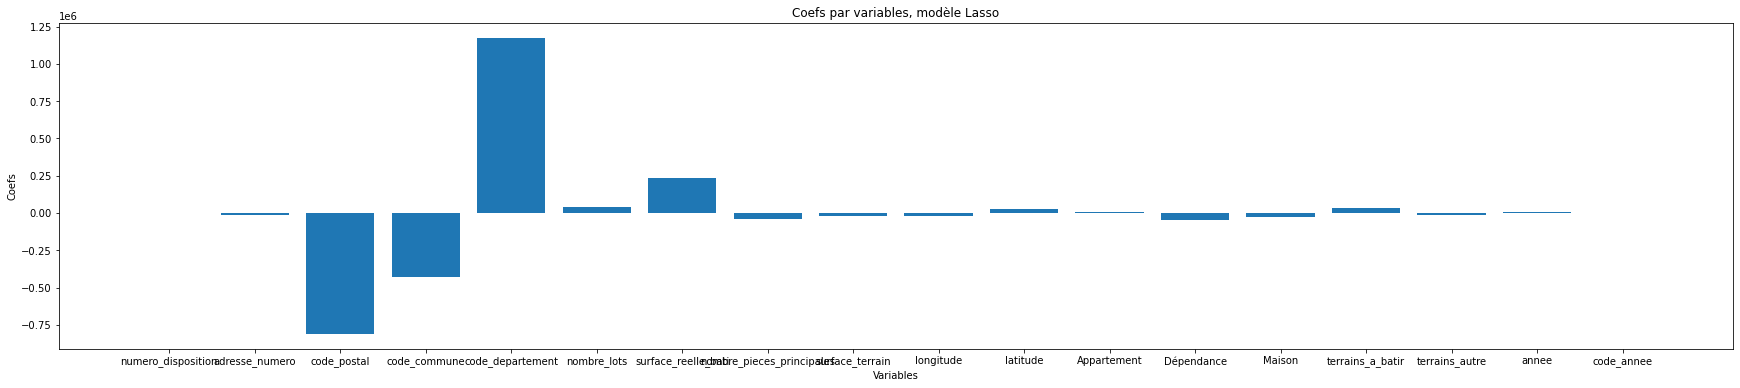

In [ ]:
plt.figure( figsize= (30, 6) )
plt.bar(X_train.columns, lasso_r.coef_)
plt.xlabel("Variables")
plt.ylabel("Coefs")
plt.title("Coefs par variables, modèle Lasso");

Le modèle de base nous donne un score d'environs 42%. Il est donc très peu performant. 

Les variables comportant les coéficients les plus élevés, sélectionnées par le modèle lasso, sont des variables de localisation: Code postale, code commune, code département. Il y a donc probablement une forte influence de la localisation sur la variable cible, mais le modèle ne parviens pas à manipuler correctement ces variables en l'état. En effet, ces variables sont au format numérique, et sont donc interprétées par le modèle comme des variables continues, ordinales. Hors, il s'agit en réalité de variables nominales. Il serait donc pertinent de dichotomiser ces variables. Nous ne le ferons d'abord que pour les codes départements, pour économiser des ressources de calcul (le nombre de modalités des codes commune ou code postal est très élevé).

Nous remarquons également que les variables numero_disposition, adresse_numero, annee et code_annee ont des coéficients associés très faibles. Nous savons que le numéro d'adresse et le numéro de disposition (numéro d'identification d'un acte de vente) n'ont aucun lien avec le prix de vente. Il n'est donc pas pertinent de les conserver. Nous savons aussi, suite à l'analyse en dataviz, que le prix de vente n'a pratiquement pas évolué sur les 3 années du dataset. Les variables annee et code_annee ne sont donc pas non plus pertinentes et peuvent êtres retirées.

### Modèle lasso sur les données transformées:

Nous allons supprimer les variables identifiées comme non pertinentes, et dichotomiser le code département, avant de recréer nos ensembles d'entrainement et de test.

In [ ]:
#Suppression des variables avec les coefs les plus bas et dichotomisation du code département:
data=data.drop(["numero_disposition", "adresse_numero", "annee", "code_annee"], axis=1)
data=data.join(pd.get_dummies(data['code_departement'], prefix='dep')).drop("code_departement", axis=1)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

#Standardisation des variables:
X_train=pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test=pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_train.head()

,code_postal,code_commune,nombre_lots,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,Appartement,Dépendance,Maison,terrains_a_batir,terrains_autre,dep_75,dep_77,dep_78,dep_91,dep_92,dep_93,dep_94,dep_95
0,1.001945,0.982281,1.025093,-0.539118,-0.757592,-0.461248,0.772669,0.018511,0.643306,0.944221,-0.625648,-0.107336,-0.207455,-0.508547,-0.363489,-0.364996,-0.354666,-0.38063,-0.337164,2.731650,-0.336516
1,0.883371,0.866359,1.787282,-0.594910,-0.757592,-0.461248,0.674036,0.215626,0.643306,2.602888,-0.625648,-0.107336,-0.207455,-0.508547,-0.363489,-0.364996,-0.354666,-0.38063,2.965912,-0.366079,-0.336516
2,-1.292103,-1.286007,1.025093,0.046694,-0.070867,-0.461248,0.058381,-0.008691,0.643306,0.944221,-0.625648,-0.107336,-0.207455,1.966386,-0.363489,-0.364996,-0.354666,-0.38063,-0.337164,-0.366079,-0.336516
3,1.113404,1.160485,-1.261475,0.018799,0.615858,0.947214,-1.159599,1.686345,-1.554470,-0.714445,1.598343,-0.107336,-0.207455,-0.508547,-0.363489,-0.364996,-0.354666,-0.38063,-0.337164,-0.366079,2.971623
4,-1.291747,-1.285647,0.262904,-1.069140,-1.444317,-0.461248,-0.411219,0.036241,0.643306,-0.714445,-0.625648,-0.107336,-0.207455,1.966386,-0.363489,-0.364996,-0.354666,-0.38063,-0.337164,-0.366079,-0.336516


In [ ]:
#Modèle lasso sur le dataset retravaillé:
lasso_r2 = Lasso().fit(X_train, y_train)
print(lasso_r2.score(X_test, y_test))

0.5865002705462182


In [ ]:
#Métriques du modèle:
lasso_r2_pred_train =lasso_r2.predict(X_train)
lasso_r2_pred_test = lasso_r2.predict(X_test)

print("Score train: ", lasso_r2.score(X_train, y_train))
print("Score test: ", lasso_r2.score(X_test, y_test))
print("\n")
print("MAE train: ", mean_absolute_error(y_train, lasso_r2_pred_train))
print("MAE test: ", mean_absolute_error(y_test, lasso_r2_pred_test))
print("\n")
print("MedAE train: ", median_absolute_error(y_train, lasso_r2_pred_train))
print("MedAE test: ", median_absolute_error(y_test, lasso_r2_pred_test))
print("\n")
print("RMSE train: ", np.sqrt(mean_squared_error(y_train, lasso_r2_pred_train)))
print("RMSE test: ", np.sqrt(mean_squared_error(y_test, lasso_r2_pred_test)))

Score train:  0.5802637318733554
Score test:  0.5865002705462182


MAE train:  125236.34966951564
MAE test:  124693.99967441423


MedAE train:  90153.08864134608
MedAE test:  89791.11863763022


RMSE train:  189400.2224220019
RMSE test:  187317.19180273497


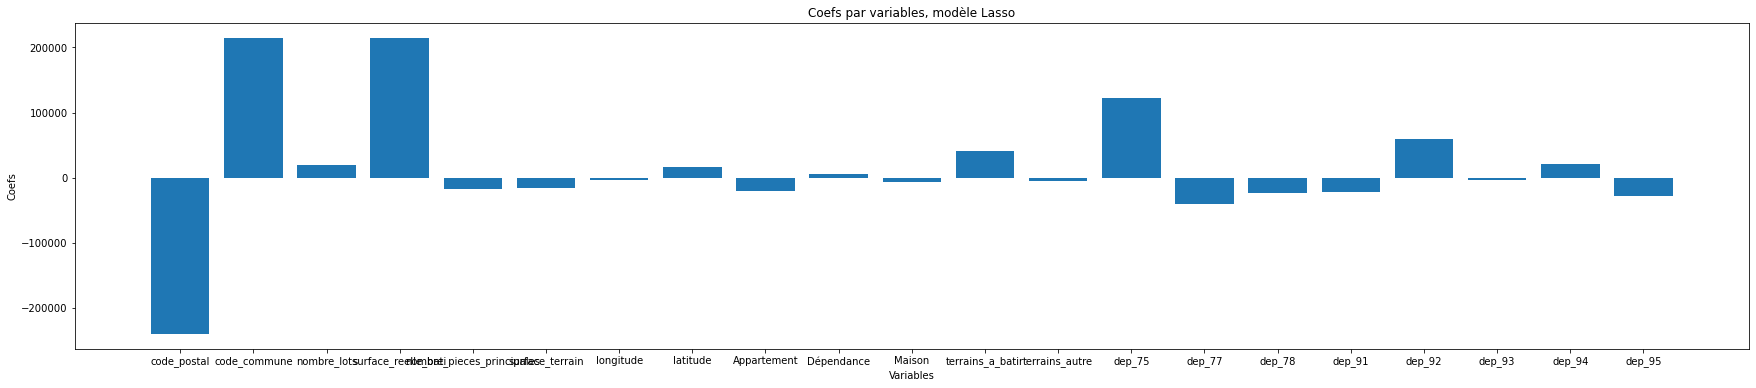

In [ ]:
plt.figure( figsize= (30, 6) )
plt.bar(X_train.columns, lasso_r2.coef_)
plt.xlabel("Variables")
plt.ylabel("Coefs")
plt.title("Coefs par variables, modèle Lasso");

Le score du modèle est légèrement meilleur. Nous remarquons que les coeficients sont importants sur les données dichotomisées. Nous remarquons aussi que le code commune et code postale conservent des coeficients très élevés, ce qui nous laisse penser que ces données nécessiteraient un traitement similaire à celui effectué sur le code département. Malheureusement, le nombre de modalités sur ces variables est très élevé (plus de 1200), et une simple dichotomisation risque de dépasser la cappacité de mémoire de calcul pour le modèle. 

Nous voyons enfin que la surface réelle à un coéficient très élevé, ce qui semble confirmer les conclusions faites sur la partie dataviz quant à l'importance prépondérente de cette variable. 

In [ ]:
print("Nombre de modalités de la variable code commune: ", len(data["code_commune"].unique()))

Nombre de modalités de la variable code commune:  1271


### Modèle lasso avec un traitement polynomial:

Lorsque nous tentons d'effectuer une régression avec de multiples données explicatives, un pré-traitement polynomial des variables peut s'avérer efficace. Nous allons donc tenter d'ajouter un traitement avec PolynomialFeatures, avec un ordre 3 sur nos données, avant d'entrainer un modèle lasso sur les données transformées.

In [ ]:
#Test avec un traitement polynomial:
poly=PolynomialFeatures(3)

X_train_poly=poly.fit_transform(X_train)
X_test_poly=poly.transform(X_test)

In [ ]:
#Modèle lasso sur le dataset avec un preprocessing polynomial
lasso_r3 = Lasso().fit(X_train_poly, y_train)
print(lasso_r3.score(X_test_poly, y_test))

0.8014424367926882


In [ ]:
#Métriques du modèle:
lasso_r3_pred_train =lasso_r3.predict(X_train_poly)
lasso_r3_pred_test = lasso_r3.predict(X_test_poly)

print("Score train: ", lasso_r3.score(X_train_poly, y_train))
print("Score test: ", lasso_r3.score(X_test_poly, y_test))
print("\n")
print("MAE train: ", mean_absolute_error(y_train, lasso_r3_pred_train))
print("MAE test: ", mean_absolute_error(y_test, lasso_r3_pred_test))
print("\n")
print("MedAE train: ", median_absolute_error(y_train, lasso_r3_pred_train))
print("MedAE test: ", median_absolute_error(y_test, lasso_r3_pred_test))
print("\n")
print("RMSE train: ", np.sqrt(mean_squared_error(y_train, lasso_r3_pred_train)))
print("RMSE test: ", np.sqrt(mean_squared_error(y_test, lasso_r3_pred_test)))

Score train:  0.7961712661105461
Score test:  0.8014424367926882


MAE train:  74753.65769236888
MAE test:  73721.0700301775


MedAE train:  43388.53912088921
MedAE test:  43059.09087755783


RMSE train:  132256.53765697073
RMSE test:  128717.41963457903


Le pré-traitement polynomial augmente considérablement le score du modèle, aux alentours de 80%. L'erreur moyenne absolue est également divisée par 2 par rapport au modèle de base. Nous allons maintenant observer plus en détails les résultats de prédiction de ce modèle:

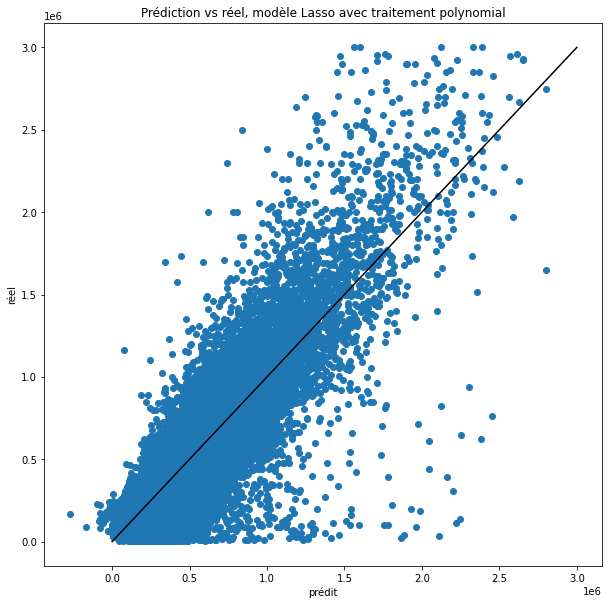

In [ ]:
#Prédiction vs réel:
plt.figure( figsize= (10, 10) )
plt.scatter(lasso_r3_pred_test, y_test)
plt.plot([0, 3000000], [0, 3000000], c="black")
plt.xlabel("prédit")
plt.ylabel("réel")
plt.title("Prédiction vs réel, modèle Lasso avec traitement polynomial");

Les prédictions suivent globalement le réel, mais reste très dispersé. Certaines prédictions sont négatives, ce qui n'a pas de sense d'un point de vue métier. 

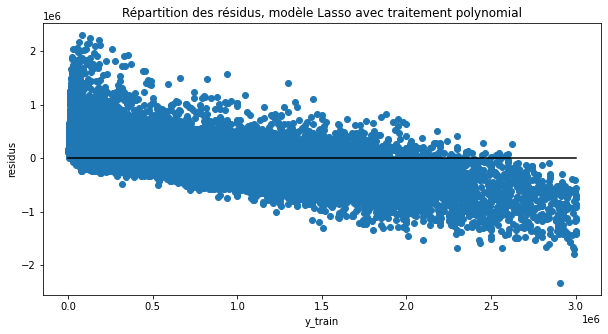

In [ ]:
residus=lasso_r3_pred_train-y_train
plt.figure( figsize= (10, 5) )
plt.scatter(y_train, residus)
plt.plot([0, max(y_train)], [0, 0], c="black")
plt.xlabel("y_train")
plt.ylabel("residus")
plt.title("Répartition des résidus, modèle Lasso avec traitement polynomial");

L'observation des résidus montre que le modèle surestime les prix faibles, et sous estime les prix élevés. 

# Conclusions:

Le modèles lasso montre des résultats correctes mais encore insuffisants. Le modèle n'arrive pas à traiter correctement les variables de localisation en l'état. La dichotomisation des codes départements et le pré-traitement polynomial se sont montrés efficaces pour améliorer les performances du modèle. 

La prochaine étape consistera à trouver une méthode efficace pour traiter les variables de localisation avant d'entrainer le modèle. Une piste consisterait à dichotomiser les codes commune, et d'apliquer des méthodes de réduction de dimentions comme l'ACP pour réduire la taille du dataset après dichotomisation. 

Par la suite, nous chercherons à optimiser les hyperparamètres de notre modèle grâce à GridSearchCV ou en utilisant le modèle LassoCV. 